# IMPORTING PACKAGES AND DATASET

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torchvision.models import resnet50, ResNet50_Weights
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from sklearn import metrics
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from PIL import Image as im
import PIL as pil
import glob
from torchsummary import summary
import tifffile

In [ ]:
seed = 3
torch.manual_seed(seed)

In [ ]:
#torch.cuda.empty_cache()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [ ]:
imageSize = 100
batch = 32
epochNumber = 25

In [ ]:
# Mounting Google Drive

from google.colab import drive
drive.mount("/content/gdrive")

MessageError: ignored

In [ ]:
#main_path = "../input/chest-xray-pneumonia/chest_xray/"
mainPath = '/content/gdrive/MyDrive/DataProjects/Chest X-Ray'


trainPath = os.path.join(mainPath,"train")
testPath=os.path.join(mainPath,"test")

trainNormal = glob.glob(trainPath+"/NORMAL/*.jpeg")
trainPneumonia = glob.glob(trainPath+"/PNEUMONIA/*.jpeg")

testNormal = glob.glob(testPath+"/NORMAL/*.jpeg")
testPneumonia = glob.glob(testPath+"/PNEUMONIA/*.jpeg")

In [ ]:
trainList = [x for x in trainNormal]
trainList.extend([x for x in trainPneumonia])

dfTrain = pd.DataFrame(np.concatenate([['Normal']*len(trainNormal) , ['Pneumonia']*len(trainPneumonia)]), columns = ['class'])
dfTrain['image'] = [x for x in trainList]

testList = [x for x in testNormal]
testList.extend([x for x in testPneumonia])

dfTest = pd.DataFrame(np.concatenate([['Normal']*len(testNormal) , ['Pneumonia']*len(testPneumonia)]), columns = ['class'])
dfTest['image'] = [x for x in testList]

In [ ]:
#trainList

In [ ]:
dfTrain

,class,image
0,Normal,/content/gdrive/MyDrive/DataProjects/Chest X-R...
1,Normal,/content/gdrive/MyDrive/DataProjects/Chest X-R...
2,Normal,/content/gdrive/MyDrive/DataProjects/Chest X-R...
3,Normal,/content/gdrive/MyDrive/DataProjects/Chest X-R...
4,Normal,/content/gdrive/MyDrive/DataProjects/Chest X-R...
...,...,...
5227,Pneumonia,/content/gdrive/MyDrive/DataProjects/Chest X-R...
5228,Pneumonia,/content/gdrive/MyDrive/DataProjects/Chest X-R...
5229,Pneumonia,/content/gdrive/MyDrive/DataProjects/Chest X-R...
5230,Pneumonia,/content/gdrive/MyDrive/DataProjects/Chest X-R...


In [ ]:
dfTest

,class,image
0,Normal,/content/gdrive/MyDrive/DataProjects/Chest X-R...
1,Normal,/content/gdrive/MyDrive/DataProjects/Chest X-R...
2,Normal,/content/gdrive/MyDrive/DataProjects/Chest X-R...
3,Normal,/content/gdrive/MyDrive/DataProjects/Chest X-R...
4,Normal,/content/gdrive/MyDrive/DataProjects/Chest X-R...
...,...,...
619,Pneumonia,/content/gdrive/MyDrive/DataProjects/Chest X-R...
620,Pneumonia,/content/gdrive/MyDrive/DataProjects/Chest X-R...
621,Pneumonia,/content/gdrive/MyDrive/DataProjects/Chest X-R...
622,Pneumonia,/content/gdrive/MyDrive/DataProjects/Chest X-R...


## LMN Dataset

In [ ]:
trainingTransforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=(imageSize, imageSize)),
        #torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.ToTensor()
])

In [ ]:
# Load the TIFF file and read the image data
tiff_file = '/content/gdrive/MyDrive/Tez/LMNDataset/ct_tiles.tif'
images = tifffile.imread(tiff_file)

# Loop over the image data and apply the transformation to each image
transformed_images = []
for i in range(images.shape[0]):
    # Apply the transformation to the current image
    # Read the image
    image = im.fromarray(images[i],'RGB')
    transformed_image = trainingTransforms(image)
    transformed_images.append(transformed_image)

In [ ]:
# Load the CSV file and read the labels
csv_file = '/content/gdrive/MyDrive/Tez/LMNDataset/malignancy.csv'
labels_df = pd.read_csv(csv_file)

# Extract the image filenames and labels from the CSV file
labels = labels_df['malignancy']

# Create a dictionary to map image filenames to their labels
preTrainSet = []

for i, j in zip(transformed_images, labels):
    preTrainSet.append({"img": i, "label": j})

In [ ]:
img = preTrainSet[0]['img']
img

tensor([[[0.0000, 0.3529, 0.7333,  ..., 0.4471, 0.5961, 0.7529],
         [0.0000, 0.3529, 0.7333,  ..., 0.4627, 0.5412, 0.6392],
         [0.0000, 0.3529, 0.7373,  ..., 0.4745, 0.4784, 0.5020],
         ...,
         [0.0000, 0.3529, 0.7255,  ..., 0.5294, 0.2314, 0.0000],
         [0.0000, 0.3529, 0.7608,  ..., 0.3529, 0.1412, 0.0000],
         [0.0000, 0.3529, 0.7882,  ..., 0.1765, 0.0510, 0.0000]],

        [[0.0000, 0.0000, 0.0745,  ..., 0.6902, 0.5882, 0.4353],
         [0.2314, 0.1255, 0.0745,  ..., 0.6902, 0.5961, 0.4510],
         [0.5255, 0.2824, 0.0784,  ..., 0.6902, 0.6000, 0.4627],
         ...,
         [0.7294, 0.3961, 0.0784,  ..., 0.6902, 0.7294, 0.6980],
         [0.3451, 0.1882, 0.0745,  ..., 0.6863, 0.7569, 0.7529],
         [0.0000, 0.0000, 0.0745,  ..., 0.6863, 0.7569, 0.7529]],

        [[0.2667, 0.1451, 0.0000,  ..., 0.0000, 0.4157, 0.7686],
         [0.3529, 0.1922, 0.0000,  ..., 0.0353, 0.4157, 0.7686],
         [0.4510, 0.2431, 0.0000,  ..., 0.0706, 0.4157, 0.

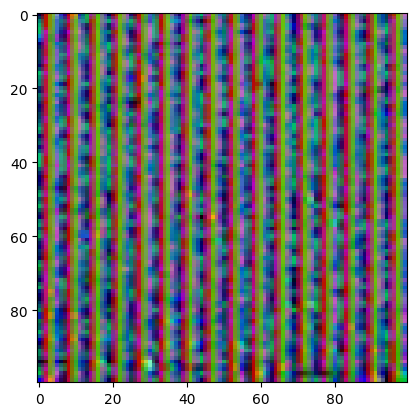

In [ ]:
img = img.permute(1,2,0)
plt.imshow(img.cpu().numpy())
plt.show()

# EXPLORING DATA

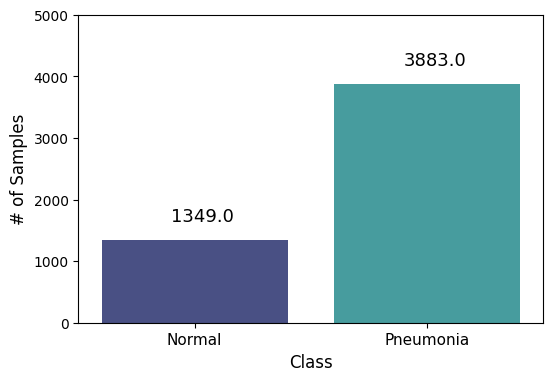

In [ ]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=dfTrain, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)

plt.show()

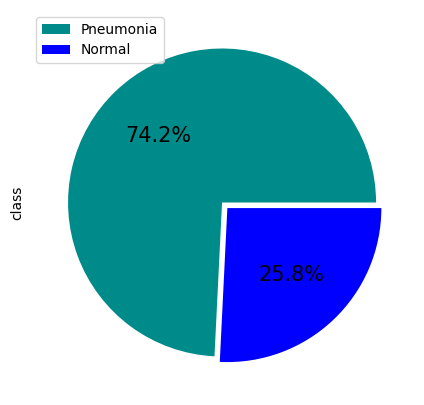

In [ ]:
plt.figure(figsize=(7,5))

dfTrain['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

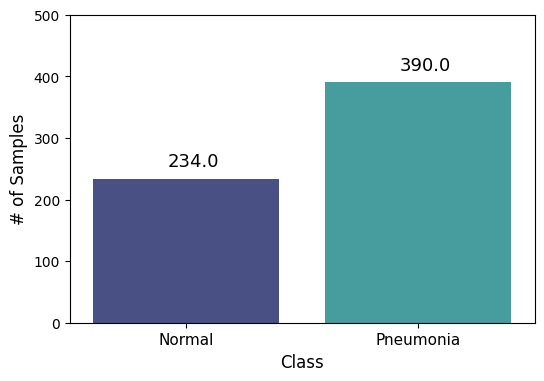

In [ ]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=dfTest, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,500)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+20), fontsize = 13)

plt.show()

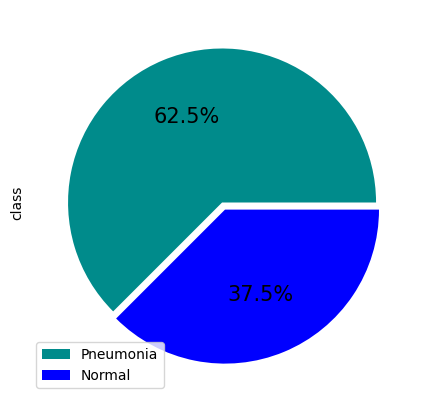

In [ ]:
plt.figure(figsize=(7,5))

dfTest['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

Train Set - Normal


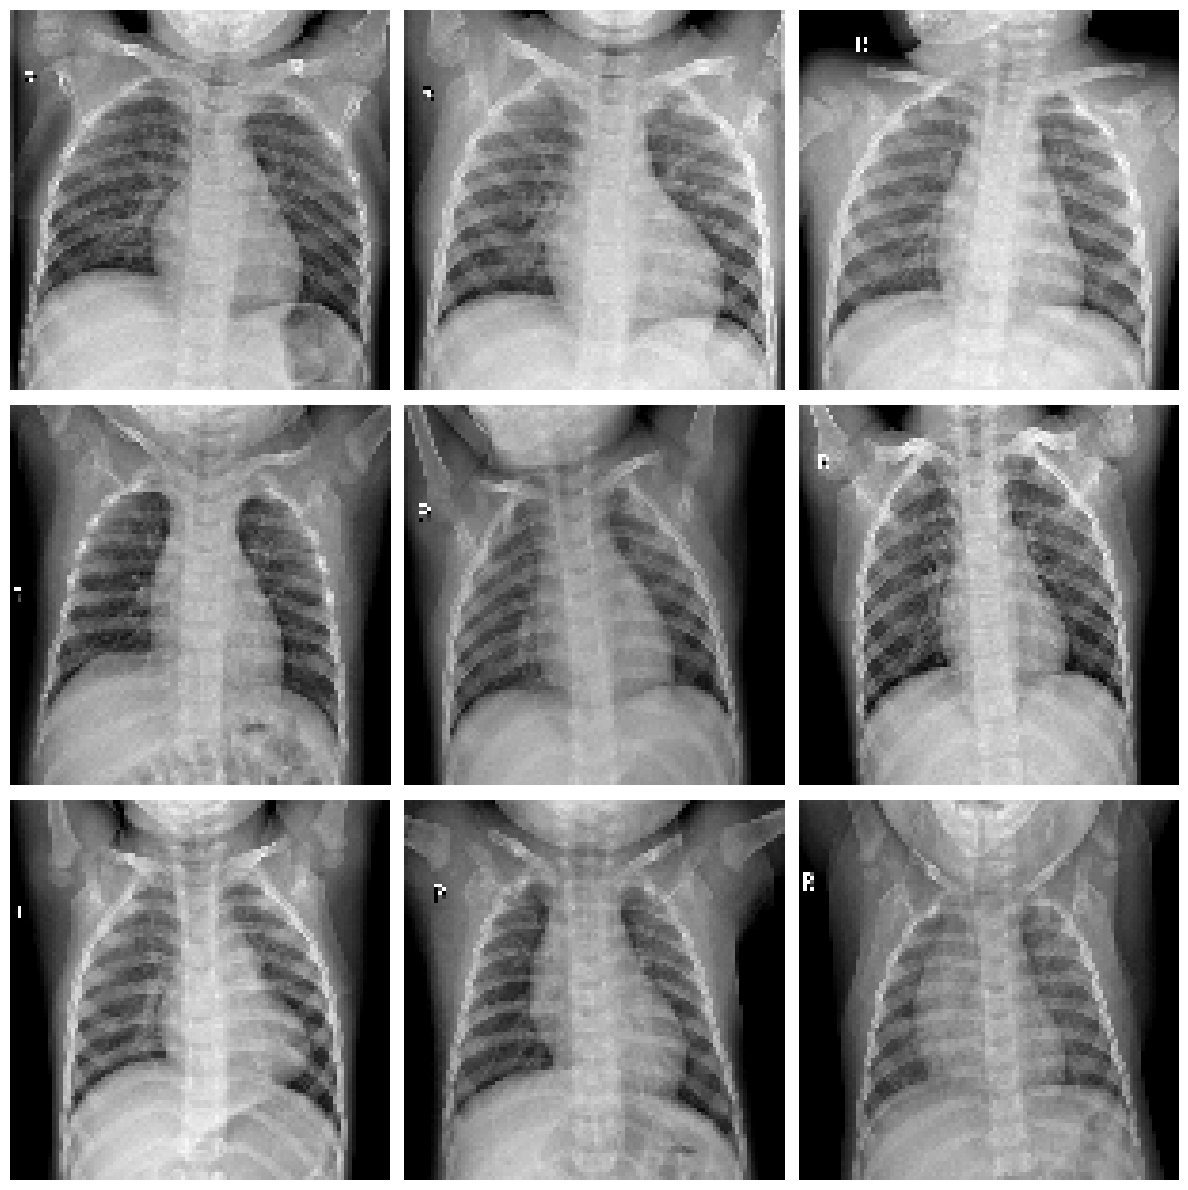

In [ ]:
print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(trainNormal[i])
    img = cv2.resize(img, (imageSize,imageSize))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Train Set - Pneumonia


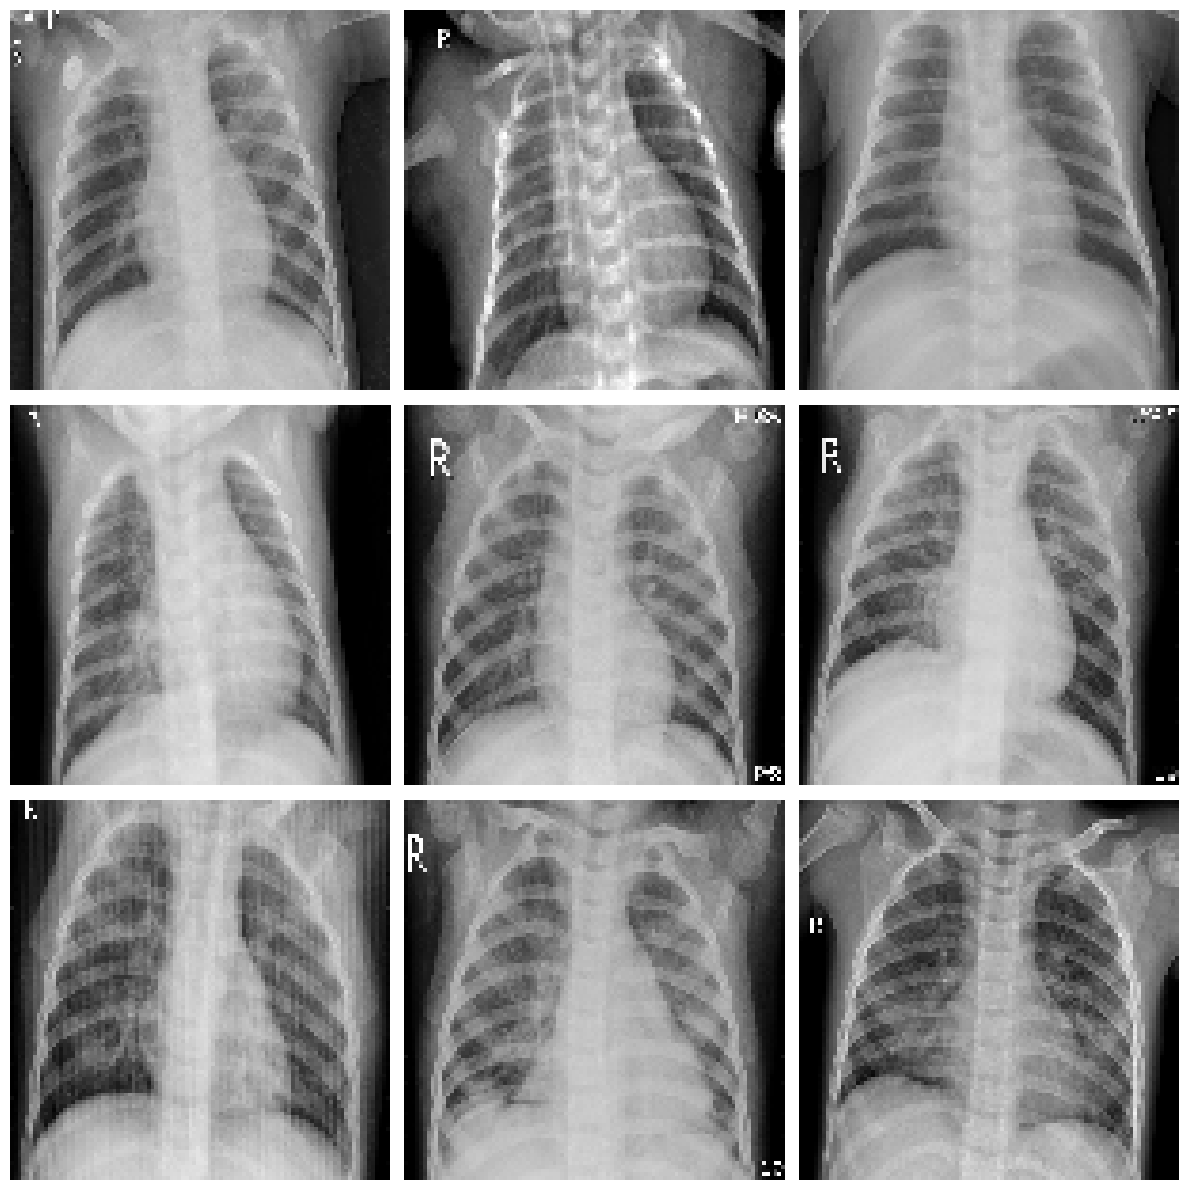

In [ ]:
print('Train Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(trainPneumonia[i])
    img = cv2.resize(img, (imageSize,imageSize))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Train Set - Normal


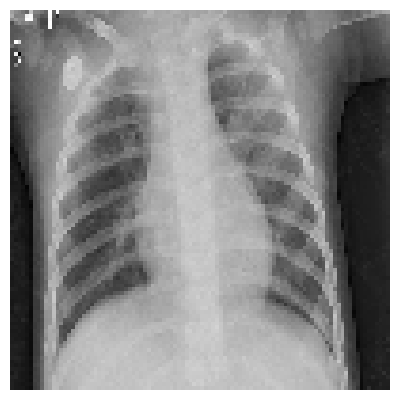

The dimensions of the image are 100 pixels width and 100 pixels height
The maximum pixel value is 255.0000 and the minimum is 3.0000
The mean value of the pixels is 128.1821 and the standard deviation is 55.8009


In [ ]:
print('Train Set - Normal')

plt.figure(figsize=(12,12))

plt.subplot(3,3,i + 1)
img = cv2.imread(trainPneumonia[0])
img = cv2.resize(img, (imageSize,imageSize))
plt.imshow(img)
plt.axis("off")

plt.tight_layout()

plt.show()


print(f"The dimensions of the image are {img.shape[0]} pixels width and {img.shape[1]} pixels height")
print(f"The maximum pixel value is {img.max():.4f} and the minimum is {img.min():.4f}")
print(f"The mean value of the pixels is {img.mean():.4f} and the standard deviation is {img.std():.4f}")

<Figure size 1500x1500 with 0 Axes>

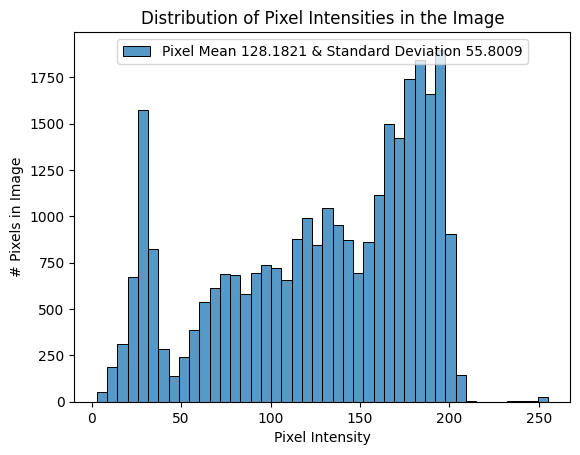

<Figure size 1500x1500 with 0 Axes>

In [ ]:
# Plot a histogram of the distribution of the pixels

sns.histplot(img.ravel(),
             label=f'Pixel Mean {img.mean():.4f} & Standard Deviation {img.std():.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
plt.figure(figsize=(15,15))

# DATA PREPROCESSING

In [ ]:
# Training dataset transforms
# Converting images to torch tensor

trainingTransforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=(imageSize, imageSize)),
        #torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.ToTensor()
])

# Validation dataset transforms
# Resizing images to 100 x 100
# Converting images to torch tensor

validationTransforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(imageSize, imageSize)),
    torchvision.transforms.ToTensor()
])


# Test dataset transforms
# Resizing images to 100 x 100
# Converting images to torch tensor

testTransforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(imageSize, imageSize)),
    torchvision.transforms.ToTensor()
])

In [ ]:
trainData = datasets.ImageFolder(root=trainPath,
                                           transform=trainingTransforms)

testData = datasets.ImageFolder(root=testPath,
                                           transform=testTransforms)

trainData, valData = train_test_split(trainData, test_size = 0.20, random_state = 42)



trainDataloader = torch.utils.data.DataLoader(trainData,
                                             batch_size=batch,
                                             shuffle=True,
                                             num_workers=4)

testDataloader = torch.utils.data.DataLoader(testData,
                                             batch_size=batch,
                                             shuffle=True,
                                             num_workers=4)

valDataloader = torch.utils.data.DataLoader(valData,
                                             batch_size=batch,
                                             shuffle=True,
                                             num_workers=4)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# preTrainDataloader = DataLoader(preTrainSet, batch_size=batch,
#                                             shuffle=True,
#                                             num_workers=4)

In [ ]:
print("Length of the test_loader:", len(trainDataloader))
print("Length of the test_loader:", len(testDataloader))
print("Length of the test_loader:", len(valDataloader))
# print("Length of the test_loader:", len(preTrainDataloader))

Length of the test_loader: 131
Length of the test_loader: 20
Length of the test_loader: 33


In [ ]:
trainData

[(tensor([[[0.1608, 0.1804, 0.3137,  ..., 0.2902, 0.3020, 0.4588],
           [0.1451, 0.1686, 0.2471,  ..., 0.3020, 0.3686, 0.4196],
           [0.1412, 0.1686, 0.2039,  ..., 0.3804, 0.3529, 0.3961],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
  
          [[0.1608, 0.1804, 0.3137,  ..., 0.2902, 0.3020, 0.4588],
           [0.1451, 0.1686, 0.2471,  ..., 0.3020, 0.3686, 0.4196],
           [0.1412, 0.1686, 0.2039,  ..., 0.3804, 0.3529, 0.3961],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
  
          [[0.1608, 0.1804, 0.3137,  ..., 0.2902, 0.3020, 0.4588],
           [0.1451, 0.1686, 0.2471,  ..., 0.3020, 0.3686, 0.4196],
           [0.1412, 0.

# MODELLING

## Functions

In [ ]:
# Defining a function that takes a model and a dataloader and outputs model accuracy on the dataloader

def check_accuracy(model, dataloader):

    predictions = []
    actual = []
    true_predictions = 0
    false_predictions = 0

    #model.eval()

    for images,labels in dataloader:

      # Move batch to GPU
      images, labels = images.cuda(), labels.cuda()

      # Run the network with images batch and obtain the class scores
      class_scores = model(images)

      # Extracting predictions from class_scores using torch.argmax() method
      class_predictions = torch.argmax(class_scores,dim=-1)
      predictions.append(class_predictions)
      actual.append(labels)

      # True and false predictions in the batch using test_labels and class_predictions
      true_predictions_batch  = torch.sum(class_predictions == labels)
      false_predictions_batch = torch.sum(class_predictions != labels)

      true_predictions  += true_predictions_batch.item()
      false_predictions += false_predictions_batch.item()

      accuracy = true_predictions / (true_predictions + false_predictions)

    predictions = torch.cat(predictions)
    actual = torch.cat(actual)

    return accuracy,predictions,actual, true_predictions,false_predictions

In [ ]:
# Training the model for 1 epoch

def train_one_epoch(neuralNet, dataloader, optimizer, loss_fn):

    #model.train()

    # runningLoss = 0

    for imgs_batch, labels_batch in dataloader:
        imgs_batch, labels_batch = imgs_batch.to("cuda"), labels_batch.to("cuda")

        # Run the network with images batch and obtain the class scores
        class_scores = neuralNet(imgs_batch)

        # Calculating loss using the loss function defined above
        loss = loss_fn(class_scores, labels_batch)

        # Taking an optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #     runningLoss += loss.item() * imgs_batch.size(0)

    # epochLoss = runningLoss / len(dataloader)
    return

In [ ]:
# # Training the model for 1 epoch

# def pre_train_one_epoch(neuralNet, dataloader, optimizer, loss_fn):

#     #model.train()

#     for imgs_batch, labels_batch in dataloader:
#         #imgs_batch, labels_batch = imgs_batch.to("cuda"), labels_batch.to("cuda")

#         # Run the network with images batch and obtain the class scores
#         class_scores = neuralNet(imgs_batch)

#         # Calculating loss using the loss function defined above
#         loss = loss_fn(class_scores, labels_batch)

#         # Taking an optimization step
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

## Custom CNN

In [ ]:
models = []
modelName = "CustomCNN"
models.append(modelName)
preTestAccuracyList = list()
postTestAccuracyList = list()

In [ ]:
# Stride of 1 for convolutional layers
# Stride of 3 for max pooling layer
# ReLU activation for hidden layers
# Batch normalization after all convolutional layers
# Dropout with 0.1 probability for the hidden fully connected layer
# Softmax activation in the final layer

class customCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Block One
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=3,stride=3)
        self.batchnorm1 = torch.nn.BatchNorm2d(num_features=16)
        self.relu = torch.nn.ReLU

        # Block Two
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=3,stride=3)
        self.batchnorm2 = torch.nn.BatchNorm2d(num_features=32)
        self.relu = torch.nn.ReLU

        # Block Three
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1)
        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=3,stride=3)
        self.batchnorm3 = torch.nn.BatchNorm2d(num_features=32)
        self.relu = torch.nn.ReLU

        # Head
        self.fc1 = torch.nn.Linear(32*1*1, 16)
        self.dropout1 = torch.nn.Dropout2d(0.1)
        self.relu = torch.nn.ReLU

        #Final Layer (Output)
        self.fc2 = torch.nn.Linear(16, 2)

    def forward(self, x):

        # Block One
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.batchnorm1(x)

        # Block Two
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.batchnorm2(x)

        # Block Three
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.batchnorm3(x)

        # Head
        x = x.view(-1,32*1*1)
        x = self.fc1(x)
        x = self.dropout1(x)

        #Final Layer (Output)
        x = self.fc2(x)
        x = torch.nn.functional.softmax(x,dim = 1)

        return x

In [ ]:
model = customCNN().to('cuda')

In [ ]:
summary(model,(3,224, 224),10)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [10, 16, 220, 220]           1,216
         MaxPool2d-2           [10, 16, 73, 73]               0
       BatchNorm2d-3           [10, 16, 73, 73]              32
            Conv2d-4           [10, 32, 69, 69]          12,832
         MaxPool2d-5           [10, 32, 23, 23]               0
       BatchNorm2d-6           [10, 32, 23, 23]              64
            Conv2d-7           [10, 32, 19, 19]          25,632
         MaxPool2d-8             [10, 32, 6, 6]               0
       BatchNorm2d-9             [10, 32, 6, 6]              64
           Linear-10                   [10, 16]             528
        Dropout2d-11                   [10, 16]               0
           Linear-12                    [10, 2]              34
Total params: 40,402
Trainable params: 40,402
Non-trainable params: 0
---------------------------------

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


## Optimizer, Loss Function

In [ ]:
# Defining optimizer
#optimizer = torch.optim.Adam(neuralNet.to('cuda').parameters())

optimizer = torch.optim.Adam(model.parameters())
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [ ]:
# Defining loss function
loss_fn = torch.nn.CrossEntropyLoss()

## Run the Simple CNN Model

In [ ]:
# Caclulating the test accuracy before training

preTestAccuracySimpleCNN, testPredictions, testActual, testTruePredictions,testFalsePredictions = check_accuracy(model, testDataloader)
preTestAccuracyList = postTestAccuracyList.append(preTestAccuracySimpleCNN)
print(f'Test accuracy before training: {preTestAccuracySimpleCNN * 100 :.2f}%')

Test accuracy before training: 71.79%


In [ ]:
# Use the training function you defined above to train your network on training set.

training_accuracy_list = []
validation_accuracy_list = []
test_accuracy_list = []
epoch_list = []

for epoch_no in range(epochNumber):
    print(f'Epoch {epoch_no + 1}...')



    train_one_epoch(model, trainDataloader, optimizer, loss_fn)
    # print(f'Training loss: {trainingLoss * 100 :.2f}%')

    training_accuracy,trainPredictions, trainActual, trainTruePredictions, trainFalsePredictions = check_accuracy(model, trainDataloader)
    print(f'Training   accuracy: {training_accuracy * 100 :.2f}%')
    validation_accuracy,validationPredictions, validationActual, validationTruePredictions, validationFalsePredictions = check_accuracy(model, valDataloader)
    test_accuracy,testPredictions,testActual, testTruePredictions, testFalsePredictions = check_accuracy(model, testDataloader)
    print(f'Validation accuracy: {validation_accuracy * 100 :.2f}%')

    training_accuracy_list.append(training_accuracy)
    validation_accuracy_list.append(validation_accuracy)
    test_accuracy_list.append(test_accuracy)
    epoch_list.append(epoch_no)

Epoch 1...
Training   accuracy: 95.44%
Validation accuracy: 95.13%
Epoch 2...
Training   accuracy: 96.37%
Validation accuracy: 94.75%
Epoch 3...
Training   accuracy: 97.75%
Validation accuracy: 95.99%
Epoch 4...
Training   accuracy: 97.80%
Validation accuracy: 95.42%
Epoch 5...
Training   accuracy: 97.92%
Validation accuracy: 97.13%
Epoch 6...
Training   accuracy: 98.14%
Validation accuracy: 95.80%
Epoch 7...
Training   accuracy: 97.99%
Validation accuracy: 95.32%
Epoch 8...
Training   accuracy: 98.69%
Validation accuracy: 96.37%
Epoch 9...
Training   accuracy: 98.69%
Validation accuracy: 96.28%
Epoch 10...
Training   accuracy: 98.52%
Validation accuracy: 96.75%
Epoch 11...
Training   accuracy: 98.42%
Validation accuracy: 97.13%
Epoch 12...
Training   accuracy: 99.09%
Validation accuracy: 97.13%
Epoch 13...
Training   accuracy: 98.95%
Validation accuracy: 97.33%
Epoch 14...
Training   accuracy: 98.47%
Validation accuracy: 97.23%
Epoch 15...
Training   accuracy: 99.28%
Validation accura

In [ ]:
# Train and Val 'Learning Curve (Loss)') over Epochs

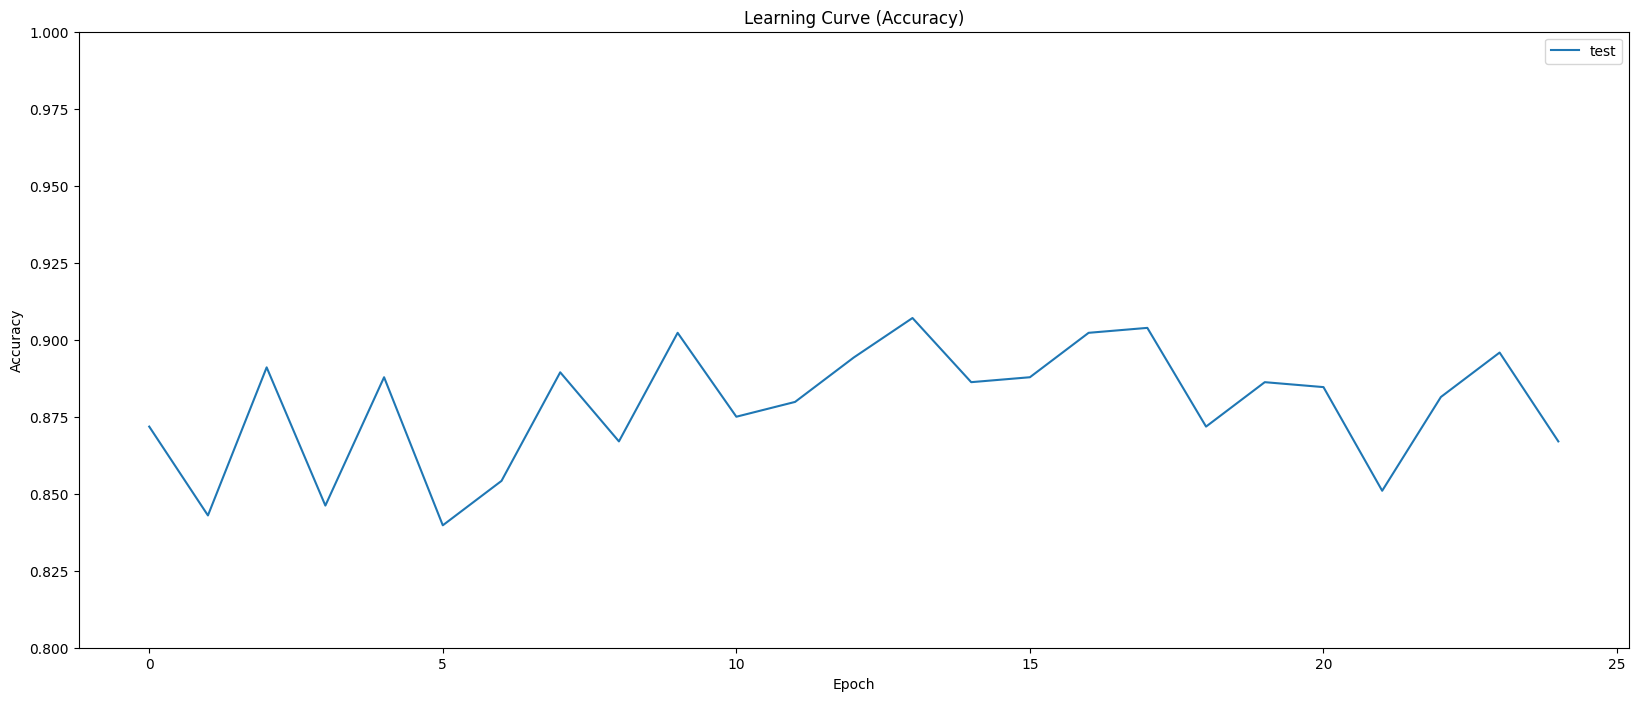

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = epoch_list, y = test_accuracy_list)
#sns.lineplot(x = epoch_list, y = validation_accuracy_list)
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['test'], loc='best')
plt.show()

In [ ]:

print('Val loss:')
print('Val accuracy:', validation_accuracy)

Val loss:
Val accuracy: 0.9694364851957975


In [ ]:
# Caclulating the test accuracy after training

postTestAccuracySimpleCNN, testPredictionsSimpleCNN, testActualSimpleCNN, testTruePredictionsSimpleCNN,testFalsePredictionsSimpleCNN = check_accuracy(model, testDataloader)
postTestAccuracyList = postTestAccuracyList.append(postTestAccuracySimpleCNN)
print('Test loss:')
print(f'Test accuracy after training: {postTestAccuracySimpleCNN * 100 :.2f}%')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Test loss:
Test accuracy after training: 86.86%


## Transfer Learning (DenseNet-169)

In [ ]:
# densenet169 = torchvision.models.densenet169(pretrained=True)
# numFeatures = densenet169.classifier.in_features
# densenet169.classifier = nn.Linear(numFeatures, 2)

In [ ]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(densenet169.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# densenet169.to('cuda')

In [ ]:
# summary(densenet169,(3,224, 224),10)

In [ ]:
# # Calculating the test accuracy before training

# test_accuracy, testPredictions, testActual, testTruePredictions,testFalsePredictions = check_accuracy(densenet169, testDataloader)
# print(f'Test accuracy before training: {test_accuracy * 100 :.2f}%')

In [ ]:
# # Use the training function you defined above to train your network on training set.

# training_accuracy_list = []
# validation_accuracy_list = []
# epoch_list = []


# for epoch_no in range(epochNumber):
#     print(f'Epoch {epoch_no + 1}...')


#     train_one_epoch(densenet169, trainDataloader, optimizer, loss_fn)

#     training_accuracy,trainPredictions, trainActual, trainTruePredictions, trainFalsePredictions = check_accuracy(densenet169, trainDataloader)
#     print(f'Training   accuracy: {training_accuracy * 100 :.2f}%')
#     validation_accuracy,validationPredictions, validationActual, validationTruePredictions, validationFalsePredictions = check_accuracy(densenet169, valDataloader)
#     print(f'Validation accuracy: {validation_accuracy * 100 :.2f}%')

#     training_accuracy_list.append(training_accuracy)
#     validation_accuracy_list.append(validation_accuracy)
#     epoch_list.append(epoch_no)

In [ ]:
# # Calculating the test accuracy after training

# test_accuracy, testPredictions, testActual, testTruePredictions,testFalsePredictions = check_accuracy(densenet169, testDataloader)
# print(f'Test accuracy after training: {test_accuracy * 100 :.2f}%')

## Transfer Learning (VGG16)

In [ ]:
modelName = "VGG-16"
models.append(modelName)

In [ ]:
vgg16 = torchvision.models.vgg16(pretrained=False)
numFeatures = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(numFeatures, 2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [ ]:
vgg16.to('cuda')

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
summary(vgg16,(3,224, 224),10)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [10, 64, 224, 224]           1,792
              ReLU-2         [10, 64, 224, 224]               0
            Conv2d-3         [10, 64, 224, 224]          36,928
              ReLU-4         [10, 64, 224, 224]               0
         MaxPool2d-5         [10, 64, 112, 112]               0
            Conv2d-6        [10, 128, 112, 112]          73,856
              ReLU-7        [10, 128, 112, 112]               0
            Conv2d-8        [10, 128, 112, 112]         147,584
              ReLU-9        [10, 128, 112, 112]               0
        MaxPool2d-10          [10, 128, 56, 56]               0
           Conv2d-11          [10, 256, 56, 56]         295,168
             ReLU-12          [10, 256, 56, 56]               0
           Conv2d-13          [10, 256, 56, 56]         590,080
             ReLU-14          [10, 256,

In [ ]:
# Calculating the test accuracy before training

preTestAccuracyVgg16, testPredictions, testActual, testTruePredictions,testFalsePredictions = check_accuracy(vgg16, testDataloader)
#preTestAccuracyList.append(preTestAccuracyVgg16)
print(f'Test accuracy before training: {preTestAccuracyVgg16 * 100 :.2f}%')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test accuracy before training: 42.79%


In [ ]:
# Use the training function you defined above to train your network on training set.

training_accuracy_list = []
validation_accuracy_list = []
epoch_list = []


for epoch_no in range(epochNumber):
    print(f'Epoch {epoch_no + 1}...')


    train_one_epoch(vgg16, trainDataloader, optimizer, loss_fn)
    # print(f'Training loss: {trainingLoss * 100 :.2f}%')

    training_accuracy,trainPredictions, trainActual, trainTruePredictions, trainFalsePredictions = check_accuracy(vgg16, trainDataloader)
    print(f'Training   accuracy: {training_accuracy * 100 :.2f}%')
    validation_accuracy,validationPredictions, validationActual, validationTruePredictions, validationFalsePredictions = check_accuracy(vgg16, valDataloader)
    print(f'Validation accuracy: {validation_accuracy * 100 :.2f}%')

    training_accuracy_list.append(training_accuracy)
    validation_accuracy_list.append(validation_accuracy)
    epoch_list.append(epoch_no)

Epoch 1...
Training   accuracy: 74.70%
Validation accuracy: 72.30%
Epoch 2...
Training   accuracy: 74.70%
Validation accuracy: 72.30%
Epoch 3...
Training   accuracy: 90.92%
Validation accuracy: 91.31%
Epoch 4...
Training   accuracy: 93.88%
Validation accuracy: 92.65%
Epoch 5...
Training   accuracy: 95.24%
Validation accuracy: 94.46%
Epoch 6...
Training   accuracy: 95.44%
Validation accuracy: 95.70%
Epoch 7...
Training   accuracy: 95.77%
Validation accuracy: 96.47%
Epoch 8...
Training   accuracy: 96.61%
Validation accuracy: 96.28%
Epoch 9...
Training   accuracy: 97.16%
Validation accuracy: 96.47%
Epoch 10...
Training   accuracy: 97.13%
Validation accuracy: 96.75%
Epoch 11...
Training   accuracy: 95.27%
Validation accuracy: 95.70%
Epoch 12...
Training   accuracy: 97.90%
Validation accuracy: 97.13%
Epoch 13...
Training   accuracy: 97.56%
Validation accuracy: 96.08%
Epoch 14...
Training   accuracy: 97.75%
Validation accuracy: 97.04%
Epoch 15...
Training   accuracy: 98.64%
Validation accura

In [ ]:
# Calculating the test accuracy after training

postTestAccuracyVgg16, testPredictionsVgg16, testActualVgg16, testTruePredictionsVgg16,testFalsePredictionsVgg16 = check_accuracy(vgg16, testDataloader)
#postTestAccuracyList = postTestAccuracyList.append(postTestAccuracyVgg16)
print(f'Test accuracy after training: {postTestAccuracyVgg16 * 100 :.2f}%')

Test accuracy after training: 84.29%


## Transfer Learning (Efficient-b1)

In [ ]:
modelName = "EfficientNet-b1"
models.append(modelName)

In [ ]:
efficientb1 = torchvision.models.efficientnet_b1(pretrained=False)
numFeatures = efficientb1.classifier[1].in_features
efficientb1.classifier[1] = nn.Linear(numFeatures, 2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(efficientb1.parameters(), lr=0.001, momentum=0.9)

In [ ]:
efficientb1.to('cuda')

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
summary(efficientb1,(3,224, 224),10)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [10, 32, 112, 112]             864
       BatchNorm2d-2         [10, 32, 112, 112]              64
              SiLU-3         [10, 32, 112, 112]               0
            Conv2d-4         [10, 32, 112, 112]             288
       BatchNorm2d-5         [10, 32, 112, 112]              64
              SiLU-6         [10, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [10, 32, 1, 1]               0
            Conv2d-8              [10, 8, 1, 1]             264
              SiLU-9              [10, 8, 1, 1]               0
           Conv2d-10             [10, 32, 1, 1]             288
          Sigmoid-11             [10, 32, 1, 1]               0
SqueezeExcitation-12         [10, 32, 112, 112]               0
           Conv2d-13         [10, 16, 112, 112]             512
      BatchNorm2d-14         [10, 16, 1

In [ ]:
# Calculating the test accuracy before training

preTestAccuracyEfficientB1, testPredictions, testActual, testTruePredictions,testFalsePredictions = check_accuracy(efficientb1, testDataloader)
#preTestAccuracyList = postTestAccuracyList.append(preTestAccuracyEfficientB1)
print(f'Test accuracy after training: {preTestAccuracyEfficientB1 * 100 :.2f}%')

Test accuracy after training: 39.74%


In [ ]:
# Use the training function you defined above to train your network on training set.

training_accuracy_list = []
validation_accuracy_list = []
epoch_list = []


for epoch_no in range(epochNumber):
    print(f'Epoch {epoch_no + 1}...')


    train_one_epoch(efficientb1, trainDataloader, optimizer, loss_fn)

    training_accuracy,trainPredictions, trainActual, trainTruePredictions, trainFalsePredictions = check_accuracy(efficientb1, trainDataloader)
    print(f'Training   accuracy: {training_accuracy * 100 :.2f}%')
    validation_accuracy,validationPredictions, validationActual, validationTruePredictions, validationFalsePredictions = check_accuracy(efficientb1, valDataloader)
    print(f'Validation accuracy: {validation_accuracy * 100 :.2f}%')

    training_accuracy_list.append(training_accuracy)
    validation_accuracy_list.append(validation_accuracy)
    epoch_list.append(epoch_no)

Epoch 1...
Training   accuracy: 87.60%
Validation accuracy: 87.11%
Epoch 2...
Training   accuracy: 91.57%
Validation accuracy: 87.77%
Epoch 3...
Training   accuracy: 92.93%
Validation accuracy: 90.93%
Epoch 4...
Training   accuracy: 95.96%
Validation accuracy: 92.93%
Epoch 5...
Training   accuracy: 96.20%
Validation accuracy: 93.31%
Epoch 6...
Training   accuracy: 96.73%
Validation accuracy: 94.46%
Epoch 7...
Training   accuracy: 97.95%
Validation accuracy: 95.13%
Epoch 8...
Training   accuracy: 97.47%
Validation accuracy: 95.80%
Epoch 9...
Training   accuracy: 97.95%
Validation accuracy: 94.84%
Epoch 10...
Training   accuracy: 98.35%
Validation accuracy: 95.99%
Epoch 11...
Training   accuracy: 98.45%
Validation accuracy: 95.89%
Epoch 12...
Training   accuracy: 99.07%
Validation accuracy: 95.51%
Epoch 13...
Training   accuracy: 98.23%
Validation accuracy: 94.75%
Epoch 14...
Training   accuracy: 99.07%
Validation accuracy: 96.08%
Epoch 15...
Training   accuracy: 99.02%
Validation accura

In [ ]:
# Calculating the test accuracy after training

postTestAccuracyEfficientB1, testPredictionsEfficientB1, testActualEfficientB1, testTruePredictionsEfficientB1,testFalsePredictionsEfficientB1 = check_accuracy(efficientb1, testDataloader)
#postTestAccuracyList = postTestAccuracyList.append(postTestAccuracyEfficientB1)
print(f'Test accuracy after training: {postTestAccuracyEfficientB1 * 100 :.2f}%')

Test accuracy after training: 83.97%


## Transfer Learning (ResNet-50)

In [ ]:
modelName = "ResNet-50"
models.append(modelName)

In [ ]:
resnet50 = torchvision.models.resnet50(pretrained=False)
numFeatures = resnet50.fc.in_features
resnet50.fc = nn.Linear(numFeatures, 2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

In [ ]:
resnet50.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
summary(resnet50,(3,224, 224),10)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [10, 64, 112, 112]           9,408
       BatchNorm2d-2         [10, 64, 112, 112]             128
              ReLU-3         [10, 64, 112, 112]               0
         MaxPool2d-4           [10, 64, 56, 56]               0
            Conv2d-5           [10, 64, 56, 56]           4,096
       BatchNorm2d-6           [10, 64, 56, 56]             128
              ReLU-7           [10, 64, 56, 56]               0
            Conv2d-8           [10, 64, 56, 56]          36,864
       BatchNorm2d-9           [10, 64, 56, 56]             128
             ReLU-10           [10, 64, 56, 56]               0
           Conv2d-11          [10, 256, 56, 56]          16,384
      BatchNorm2d-12          [10, 256, 56, 56]             512
           Conv2d-13          [10, 256, 56, 56]          16,384
      BatchNorm2d-14          [10, 256,

In [ ]:
# # Freeze the parameters of the base model
# for param in resnet50.parameters():
#     param.requires_grad = True

In [ ]:
# summary(resnet50,(3,224, 224),10)

In [ ]:
# # Freeze all layers except the last 65 layers

# l = [module for module in resnet50.modules() if not isinstance(module, nn.Sequential)]

# for j in range(1,7):
#   for param in l[-j].parameters():
#     param.requires_grad = True

In [ ]:
# summary(resnet50,(3,224, 224),10)

In [ ]:
# Calculating the test accuracy before training

preTestAccuracyResnet50, testPredictions, testActual, testTruePredictions,testFalsePredictions = check_accuracy(resnet50, testDataloader)
#preTestAccuracyList = postTestAccuracyList.append(preTestAccuracyResnet50)
print(f'Test accuracy before training: {preTestAccuracyResnet50 * 100 :.2f}%')

Test accuracy before training: 56.09%


In [ ]:
# Use the training function you defined above to train your network on training set.

training_accuracy_list = []
validation_accuracy_list = []
epoch_list = []


for epoch_no in range(epochNumber):
    print(f'Epoch {epoch_no + 1}...')


    train_one_epoch(resnet50, trainDataloader, optimizer, loss_fn)

    training_accuracy,trainPredictions, trainActual, trainTruePredictions, trainFalsePredictions = check_accuracy(resnet50, trainDataloader)
    print(f'Training   accuracy: {training_accuracy * 100 :.2f}%')
    validation_accuracy,validationPredictions, validationActual, validationTruePredictions, validationFalsePredictions = check_accuracy(resnet50, valDataloader)
    print(f'Validation accuracy: {validation_accuracy * 100 :.2f}%')

    training_accuracy_list.append(training_accuracy)
    validation_accuracy_list.append(validation_accuracy)
    epoch_list.append(epoch_no)

Epoch 1...
Training   accuracy: 85.97%
Validation accuracy: 84.34%
Epoch 2...
Training   accuracy: 91.18%
Validation accuracy: 90.64%
Epoch 3...
Training   accuracy: 93.38%
Validation accuracy: 92.93%
Epoch 4...
Training   accuracy: 95.01%
Validation accuracy: 93.03%
Epoch 5...
Training   accuracy: 95.53%
Validation accuracy: 92.55%
Epoch 6...
Training   accuracy: 95.72%
Validation accuracy: 93.98%
Epoch 7...
Training   accuracy: 96.92%
Validation accuracy: 94.75%
Epoch 8...
Training   accuracy: 97.47%
Validation accuracy: 95.80%
Epoch 9...
Training   accuracy: 98.28%
Validation accuracy: 96.08%
Epoch 10...
Training   accuracy: 96.89%
Validation accuracy: 94.46%
Epoch 11...
Training   accuracy: 98.66%
Validation accuracy: 95.89%
Epoch 12...
Training   accuracy: 96.82%
Validation accuracy: 94.36%
Epoch 13...
Training   accuracy: 98.61%
Validation accuracy: 95.99%
Epoch 14...
Training   accuracy: 99.04%
Validation accuracy: 95.22%
Epoch 15...
Training   accuracy: 98.85%
Validation accura

In [ ]:
# Caclulating the test accuracy after training

postTestAccuracyResnet50, testPredictionsResnet50, testActualResnet50, testTruePredictionsResnet50,testFalsePredictionsResnet50 = check_accuracy(resnet50, testDataloader)
#postTestAccuracyList = postTestAccuracyList.append(postTestAccuracyResnet50)
print(f'Test accuracy after training: {postTestAccuracyResnet50 * 100 :.2f}%')

Test accuracy after training: 86.54%


## LMN PreTraining

In [ ]:
# resnet50PreTrain = torchvision.models.resnet50(pretrained=True)
# numFeatures = resnet50PreTrain.fc.in_features
# resnet50PreTrain.fc = nn.Linear(numFeatures, 2)

In [ ]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(resnet50PreTrain.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# resnet50PreTrain.to('cuda')

In [ ]:
# # Calculating the test accuracy before training

# test_accuracy, testPredictions, testActual, testTruePredictions,testFalsePredictions = check_accuracy(resnet50PreTrain, testDataloader)
# print(f'Test accuracy before training: {test_accuracy * 100 :.2f}%')

In [ ]:
# for epoch_no in range(epochNumber):
#     print(f'Epoch {epoch_no + 1}...')


#     pre_train_one_epoch(resnet50PreTrain, preTrainDataloader, optimizer, loss_fn)

In [ ]:
# # Use the training function you defined above to train your network on training set.

# training_accuracy_list = []
# validation_accuracy_list = []
# epoch_list = []


# for epoch_no in range(epochNumber):
#     print(f'Epoch {epoch_no + 1}...')


#     train_one_epoch(resnet50PreTrain, trainDataloader, optimizer, loss_fn)

#     training_accuracy,trainPredictions, trainActual, trainTruePredictions, trainFalsePredictions = check_accuracy(resnet50PreTrain, trainDataloader)
#     print(f'Training   accuracy: {training_accuracy * 100 :.2f}%')
#     validation_accuracy,validationPredictions, validationActual, validationTruePredictions, validationFalsePredictions = check_accuracy(resnet50PreTrain, valDataloader)
#     print(f'Validation accuracy: {validation_accuracy * 100 :.2f}%')

#     training_accuracy_list.append(training_accuracy)
#     validation_accuracy_list.append(validation_accuracy)
#     epoch_list.append(epoch_no)

In [ ]:
# # Calculating the test accuracy after training

# test_accuracy, testPredictions, testActual, testTruePredictions,testFalsePredictions = check_accuracy(resnet50PreTrain, testDataloader)
# print(f'Test accuracy after training: {test_accuracy * 100 :.2f}%')

# Performance Metrics

In [ ]:
# testActual = testActualSimpleCNN.cpu().numpy()
# testPredictions = testPredictionsSimpleCNN.cpu().numpy()
# num_label = {'Normal': 0, 'Pneumonia' : 1}

In [ ]:
# testActual = testActualVgg16.cpu().numpy()
# testPredictions = testPredictionsVgg16.cpu().numpy()
# num_label = {'Normal': 0, 'Pneumonia' : 1}

In [ ]:
# testActual = testActualEfficientB1.cpu().numpy()
# testPredictions = testPredictionsEfficientB1.cpu().numpy()
# num_label = {'Normal': 0, 'Pneumonia' : 1}

In [ ]:
testActual = testActualResnet50.cpu().numpy()
testPredictions = testPredictionsResnet50.cpu().numpy()
num_label = {'Normal': 0, 'Pneumonia' : 1}

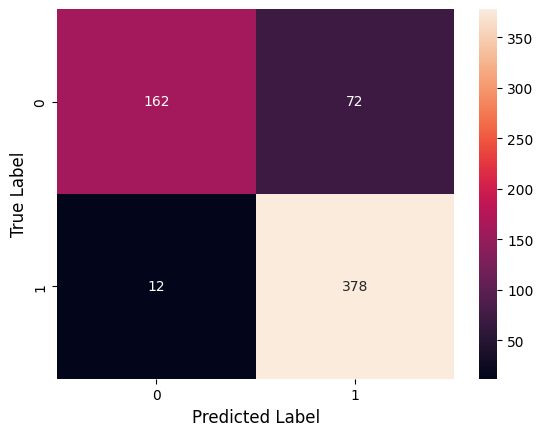

In [ ]:
confusion_matrix = metrics.confusion_matrix(testActual, testPredictions)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [ ]:
print(metrics.classification_report(testActual, testPredictions))

              precision    recall  f1-score   support

           0       0.93      0.69      0.79       234
           1       0.84      0.97      0.90       390

    accuracy                           0.87       624
   macro avg       0.89      0.83      0.85       624
weighted avg       0.87      0.87      0.86       624



ROC_AUC:  0.8307692307692307


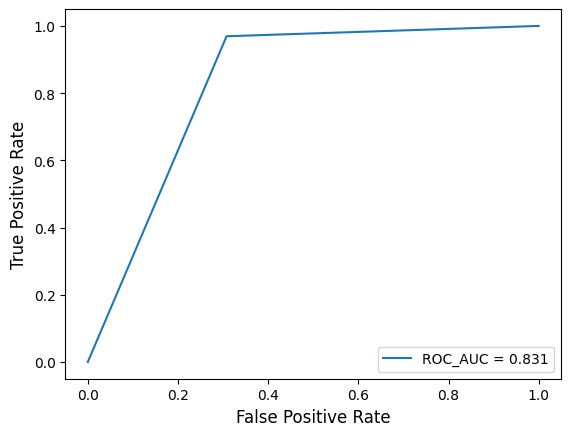

In [ ]:
roc_auc = metrics.roc_auc_score(testActual, testPredictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(testActual, testPredictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()